In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('./data/aggregate_201027.csv')
target = 'reuse'
IDcol = 'project'
train = train[pd.notnull(train['maven_reuse'])]
train = train[train.class_count != 0]
train = train[train.maven_reuse <1570]
train.dropna(axis=1, inplace=True)
train['date'] = pd.to_datetime(train['maven_release'])

In [2]:
train.head()

,project,release,maven_reuse,maven_release,class_count,protectedFieldsQty_sum,protectedFieldsQty_stdev,protectedFieldsQty_median,protectedFieldsQty_min,protectedFieldsQty_max,...,stringLiteralsQty_stdev,stringLiteralsQty_median,stringLiteralsQty_min,stringLiteralsQty_max,tcc_sum,tcc_stdev,tcc_median,tcc_min,tcc_max,date
0,aalto-xml,1.0.0,23.0,"Nov, 2015",133,149.0,2.724851,0.0,0.0,18.0,...,19.963304,6.0,0.0,105.0,0.0,0.000000,0.0,0.0,0.0,2015-11-01
1,airline,0.7,49.0,"Nov, 2014",67,76.0,2.138362,0.0,0.0,9.0,...,45.064796,4.0,0.0,315.0,-21.0,0.488504,0.0,-1.0,0.0,2014-11-01
2,akka-actor,2.5.23,208.0,"Jun, 2019",487,848.0,5.790122,0.0,0.0,53.0,...,18.130864,3.0,0.0,239.0,-44.0,0.317493,0.0,-1.0,0.0,2019-06-01
3,akka-remote,2.3.14,31.0,"Sep, 2015",235,229.0,3.732268,0.0,0.0,41.0,...,9.604021,2.0,0.0,86.0,-20.0,0.347038,0.0,-1.0,0.0,2015-09-01
4,akka-slf4j,2.5.23,135.0,"Jun, 2019",487,848.0,5.790122,0.0,0.0,53.0,...,18.130864,3.0,0.0,239.0,-44.0,0.317493,0.0,-1.0,0.0,2019-06-01


In [3]:
import datetime as dt

In [4]:
train['day'] = (dt.datetime.now() - train['date']).dt.days

In [5]:
train.head()

,project,release,maven_reuse,maven_release,class_count,protectedFieldsQty_sum,protectedFieldsQty_stdev,protectedFieldsQty_median,protectedFieldsQty_min,protectedFieldsQty_max,...,stringLiteralsQty_median,stringLiteralsQty_min,stringLiteralsQty_max,tcc_sum,tcc_stdev,tcc_median,tcc_min,tcc_max,date,day
0,aalto-xml,1.0.0,23.0,"Nov, 2015",133,149.0,2.724851,0.0,0.0,18.0,...,6.0,0.0,105.0,0.0,0.000000,0.0,0.0,0.0,2015-11-01,1822
1,airline,0.7,49.0,"Nov, 2014",67,76.0,2.138362,0.0,0.0,9.0,...,4.0,0.0,315.0,-21.0,0.488504,0.0,-1.0,0.0,2014-11-01,2187
2,akka-actor,2.5.23,208.0,"Jun, 2019",487,848.0,5.790122,0.0,0.0,53.0,...,3.0,0.0,239.0,-44.0,0.317493,0.0,-1.0,0.0,2019-06-01,514
3,akka-remote,2.3.14,31.0,"Sep, 2015",235,229.0,3.732268,0.0,0.0,41.0,...,2.0,0.0,86.0,-20.0,0.347038,0.0,-1.0,0.0,2015-09-01,1883
4,akka-slf4j,2.5.23,135.0,"Jun, 2019",487,848.0,5.790122,0.0,0.0,53.0,...,3.0,0.0,239.0,-44.0,0.317493,0.0,-1.0,0.0,2019-06-01,514


In [6]:
train.describe()

,maven_reuse,class_count,protectedFieldsQty_sum,protectedFieldsQty_stdev,protectedFieldsQty_median,protectedFieldsQty_min,protectedFieldsQty_max,nosi_sum,nosi_stdev,nosi_median,...,stringLiteralsQty_stdev,stringLiteralsQty_median,stringLiteralsQty_min,stringLiteralsQty_max,tcc_sum,tcc_stdev,tcc_median,tcc_min,tcc_max,day
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.0,261.000000,261.000000,261.000000,261.000000,...,261.000000,261.000000,261.0,261.000000,261.000000,261.000000,261.000000,261.000000,261.0,261.000000
mean,205.475096,891.229885,1657.130268,3.194075,0.779693,0.0,28.275862,3872.812261,12.960124,1.672414,...,36.160592,3.850575,0.0,465.885057,-30.034483,0.146322,-0.007663,-0.708812,0.0,1472.409962
std,276.933143,1777.604157,3505.805068,2.250908,1.197084,0.0,28.349613,8295.363605,13.336002,3.454786,...,49.177748,8.329090,0.0,756.655517,63.379222,0.129341,0.087369,0.455183,0.0,929.306754
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,-315.000000,0.000000,-1.000000,-1.000000,0.0,26.000000
25%,33.000000,42.000000,51.000000,1.870829,0.000000,0.0,9.000000,155.000000,5.408462,0.000000,...,10.087965,1.000000,0.0,56.000000,-21.000000,0.000000,0.000000,-1.000000,0.0,757.000000
50%,65.000000,169.000000,229.000000,2.990541,1.000000,0.0,20.000000,746.000000,9.079811,1.000000,...,20.112185,3.000000,0.0,172.000000,-2.000000,0.142119,0.000000,-1.000000,0.0,1395.000000
75%,304.000000,487.000000,894.000000,3.687818,1.000000,0.0,44.000000,2176.000000,15.246689,2.000000,...,45.085495,4.000000,0.0,436.000000,0.000000,0.204124,0.000000,0.000000,0.0,2006.000000
max,1501.000000,9728.000000,17767.000000,19.091883,13.500000,0.0,224.000000,50295.000000,98.909049,43.500000,...,444.144898,105.000000,0.0,6540.000000,0.000000,0.577350,0.000000,0.000000,0.0,4317.000000


In [7]:
np.nanpercentile(train['maven_reuse'], [20, 40, 60, 80])

array([ 28.,  49., 113., 406.])

In [8]:
np.nanpercentile(train['maven_reuse'], [10, 20, 30, 40, 50, 60, 70, 80,85, 90, 92,95, 97, 99])

array([  18. ,   28. ,   38. ,   49. ,   65. ,  113. ,  212. ,  406. ,
        450. ,  558. ,  603.2,  778. ,  895.8, 1285.4])

In [9]:
def f(x):
    arr = [13, 36, 77.6, 369]
    for i in range(len(arr)+1):
        if i == len(arr):
            return int(i)
        if x['maven_reuse']<arr[i]:
            return int(i) 
train['reuse_5'] = train.apply(f, axis=1)

In [10]:
def f(x):
    arr = [49, 406]
    for i in range(len(arr)+1):
        if i == len(arr):
            return int(i)
        if x['maven_reuse']<arr[i]:
            return int(i) 
train['reuse_3'] = train.apply(f, axis=1)

<AxesSubplot:>

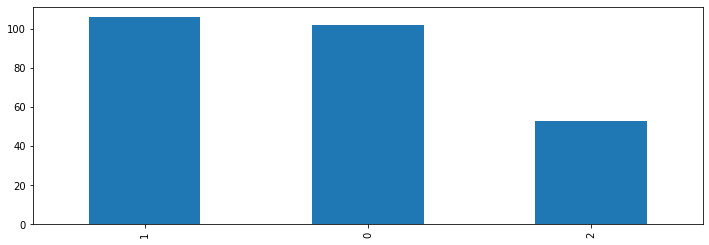

In [11]:
train.reuse_3.value_counts().plot(kind='bar')

In [12]:
def f(x):
    arr = [29, 50.6, 160, 600.2,964.12, 3066.38]
    for i in range(len(arr)+1):
        if i == len(arr):
            return int(i)
        if x['maven_reuse']<arr[i]:
            return int(i) 
train['reuse_10'] = train.apply(f, axis=1)

<AxesSubplot:>

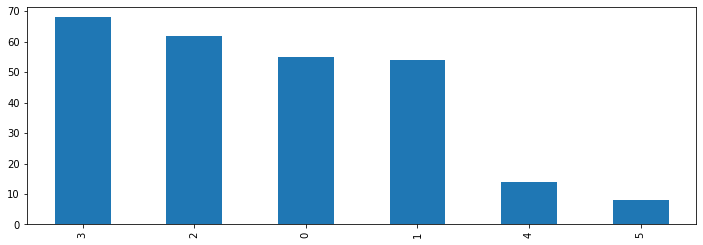

In [13]:
train.reuse_10.value_counts().plot(kind='bar')

In [14]:
train.corr()

,maven_reuse,class_count,protectedFieldsQty_sum,protectedFieldsQty_stdev,protectedFieldsQty_median,protectedFieldsQty_min,protectedFieldsQty_max,nosi_sum,nosi_stdev,nosi_median,...,stringLiteralsQty_max,tcc_sum,tcc_stdev,tcc_median,tcc_min,tcc_max,day,reuse_5,reuse_3,reuse_10
maven_reuse,1.000000,0.257974,0.235334,-0.109417,-0.035620,NaN,0.055246,0.226935,0.008398,-0.050996,...,0.084628,-0.278137,0.062665,0.008894,-0.051965,NaN,-0.169743,0.750947,0.786741,0.836622
class_count,0.257974,1.000000,0.987472,0.024444,0.042245,NaN,0.450594,0.905286,-0.016873,-0.120919,...,0.518737,-0.831605,0.135738,0.041443,-0.301450,NaN,-0.342826,0.351159,0.332884,0.272809
protectedFieldsQty_sum,0.235334,0.987472,1.000000,0.053093,0.071844,NaN,0.441051,0.922823,-0.009255,-0.105660,...,0.516486,-0.788893,0.103465,0.040863,-0.286341,NaN,-0.345200,0.331369,0.310997,0.252997
protectedFieldsQty_stdev,-0.109417,0.024444,0.053093,1.000000,0.472037,NaN,0.603764,0.045715,0.173125,0.186987,...,0.151710,0.004707,-0.041281,0.066294,-0.082765,NaN,0.007002,-0.104336,-0.084664,-0.087228
protectedFieldsQty_median,-0.035620,0.042245,0.071844,0.472037,1.000000,NaN,0.023614,0.040514,-0.076338,0.242184,...,-0.034817,0.005324,-0.259941,0.057345,0.192299,NaN,0.061697,-0.013469,-0.007702,-0.024554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcc_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,-0.169743,-0.342826,-0.345200,0.007002,0.061697,NaN,-0.208011,-0.342507,-0.040156,0.122060,...,-0.204479,0.302242,-0.213809,0.018703,0.261643,NaN,1.000000,-0.206240,-0.162510,-0.132271
reuse_5,0.750947,0.351159,0.331369,-0.104336,-0.013469,NaN,0.059533,0.334681,0.071283,0.009775,...,0.151764,-0.345599,0.083785,-0.046294,-0.088456,NaN,-0.206240,1.000000,0.890976,0.908271
reuse_3,0.786741,0.332884,0.310997,-0.084664,-0.007702,NaN,0.086874,0.315109,0.068301,0.002153,...,0.145956,-0.340252,0.051249,-0.022073,-0.075959,NaN,-0.162510,0.890976,1.000000,0.892330


In [15]:
[29, 50.6, 283.3, 780.2, 1541.7, 3066.38] 
0.736068
[29, 50.6, 160, 557.65, 3066.38, 5120.27]
0.652016
[29, 50.6, 160, 780.2, 1541.7, 3066.38, 5120.27]
0.740948

0.740948

Here we realise that the less reusable projects need to be put in bigger more general groups and the higher level reuse projects require that we be more specific in the way we classify them => this for correlation to increase

In [ ]:
print(len(train['reuse_5']))

In [ ]:
for i in train['reuse_5']:
    print(i)

In [ ]:
def f(x):
    if x['maven_reuse'] < 19: return 0
    elif x['maven_reuse'] < 243 and x['maven_reuse']>=19: return 1
    else: return 2

train['reuse'] = train.apply(f, axis=1)

In [ ]:
train.corr()